# Estimating selection in maize using NGS data


For this exercise, we will be working on a dataset that consists of maize genomes from modern and ancient samples. In the first exercise, we will look for selection in 15 domesticated maize (*Zea mays* subsp. *mays*) genomes by estimating Tajima's D. In the second exercise, we will look for selection in a specific population of maize from Eastern North America using the Population Branch Statistic (PBS).

### Setup enviroment

In [1]:
COURSE_PATH=/course/popgen25
DATA_PATH=$COURSE_PATH/selection
SOFTWARE_PATH=$COURSE_PATH/software

echo --programs that are installed:--
type angsd
type realSFS
type thetaStat

#make folder 
FOLDER=~/SelectionExercise/
echo -e "\n--creating folder-- "
echo $FOLDER
mkdir -p $FOLDER

# enter folder
cd $FOLDER

#make sym link for data and current folder
ln -sfn $FOLDER ~/current_folder
ln -sfn $DATA_PATH ~/data_folder

--programs that are installed:--
angsd is /usr/local/bin/angsd
realSFS is /usr/bin/realSFS
thetaStat is /usr/bin/thetaStat

--creating folder-- 
/home/jupyter-anders/SelectionExercise/



### Estimating Tajima's D in domesticated maize
For this exercise we will use 15 domesticated maize genomes from different varieties to look for signatures of selection that the domestication process might have left. For this, we have 15 BAM files with sequencing data for maize chromosome 4:

In [2]:
#Go to the working directory where we have the data:

# make links to files and add them to the folder
cp -r -sf  ${DATA_PATH}/bamfiles .
cp -sf ${DATA_PATH}/*fa.gz .
cp -sf ${DATA_PATH}/*fai .

#You can check which files we have in this directory by typing 'ls': 
#list of BAM files with domesticated maize data: 
echo -e "\n-- files in folder "
ls

echo -e "\n-- files in bamfiles folder "
ls bamfiles


-- files in folder 
B73v3_25.fa                      parviglumis_ds1.arg
B73v3_25.fa.fai                  parviglumis_ds1.saf.gz
B73v3_25.fa.gz                   parviglumis_ds1.saf.idx
B73v3_25.fa.gz.fai               parviglumis_ds1.saf.pos.gz
B73v3_25.fa.gz.gzi               parviglumis_ozark.sfs
bamfiles                         parviglumis_ozark_sw750_chr9_5Kwin
chr4_sfs.pdf                     parviglumis_ozark_sw750.fst.gz
DomesticatedMaize.txt            parviglumis_ozark_sw750.fst.idx
maize_chr4.arg                   parviglumis_sw750.sfs
maize_chr4.log                   parviglumis.txt
maize_chr4.saf.gz                pbs_ozarks_5Kwin.pdf
maize_chr4.saf.idx               run
maize_chr4.saf.pos.gz            sw750_ds1.arg
maize_chr4.sfs                   sw750_ds1.saf.gz
maize_chr4.thetas.5kWind.pestPG  sw750_ds1.saf.idx
maize_chr4.thetas.gz             sw750_ds1.saf.pos.gz
maize_chr4.thetas.idx            SW750.txt
Maize_migNorth.png               TajimasD_5Kwin.pdf
ozark_ds1

Now, let's create a list with the BAM files that we will be using:

In [3]:
#All the modern maize BAM files start with 'RIM'
ls bamfiles/RIM*.bam > DomesticatedMaize.txt

echo -e "\b first lines of file"
head DomesticatedMaize.txt

 first lines of file
bamfiles/RIMMA0383.bam
bamfiles/RIMMA0384.bam
bamfiles/RIMMA0385.bam
bamfiles/RIMMA0387.bam
bamfiles/RIMMA0415.bam
bamfiles/RIMMA0421.bam
bamfiles/RIMMA0623.bam
bamfiles/RIMMA0625.bam
bamfiles/RIMMA0626.bam
bamfiles/RIMMA0670.bam



#### 1. Estimate Genotype-likelihoods (GL)
Now we can estimate GL using ANGSD -doSaf:


In [4]:
# do not run
# command takes to long (~Min)
# you can run it after class if you want
#angsd -bam DomesticatedMaize.txt \
#    -ref B73v3_25.fa.gz \
#    -anc TDD39103.fa.gz \
#    -out maize_chr4 \
#    -doSaf 1 \
#    -C 50 -baq 1 \
#    -GL 2 \
#    -P 5 \
#    -minMapQ 30 \
#    -minQ 20 \
#    -minInd 10 \
#    -setMinDepth 3 \
#    -doCounts 1 \
#    -r 4:1-242029974

Check which parameters we are using and make sure they make sense to you.

This step takes too long to run so wecopy the results from the **res** directory like this (ANGSD outputs three files: maize_chr4.saf.gz, maize_chr4.saf.pos.gz and maize_chr4.saf.idx):

In [5]:
# copy results of the command and print the log    
cp ~/data_folder/res/maize_chr4* .
cat maize_chr4.log

-> angsd version: 0.941-21-g8a58e17 (htslib: 1.18-17-g5acbc15) build(Sep 10 2023 10:54:12)
	-> angsd -bam DomesticatedMaize.txt -ref B73v3_25.fa -anc TDD39103.fa -out maize_chr4 -doSaf 1 -C 50 -baq 1 -GL 2 -P 5 -minMapQ 30 -minQ 20 -minInd 10 -setMinDepth 3 -doCounts 1 -r 4:1-242029974 
	-> Inputtype is BAM/CRAM
[W::bam_hdr_read] EOF marker is absent. The input is probably truncated
[multiReader] 15 samples in 15 input files
	-> Reading fasta: TDD39103.fa
	-> Reading fasta: B73v3_25.fa
	-> Parsing 15 number of samples 
	-> Region lookup 1/1

	-> Allocated ~ 10 million nodes to the nodepool, this is not an estimate of the memory usage

	-> Allocated ~ 20 million nodes to the nodepool, this is not an estimate of the memory usage

	-> Allocated ~ 30 million nodes to the nodepool, this is not an estimate of the memory usage

	-> Allocated ~ 40 million nodes to the nodepool, this is not an estimate of the memory usage

	-> Allocated ~ 50 million nodes to the nodepool, this is not an estimat

#### 2. Estimate the SFS using realSFS
We will use realSFS to obtain an estimate of the SFS for domesticated maize. Note that we are providing realSFS the file that ends in *.idx*, which is the index for the GL that we generated before:

In [6]:
realSFS maize_chr4.saf.idx > maize_chr4.sfs


[persaf::persaf_init] Version of maize_chr4.saf.idx is 3
[persaf::persaf_init] Assuming .saf.gz file is maize_chr4.saf.gz
[persaf::persaf_init] Assuming .saf.pos.gz file is maize_chr4.saf.pos.gz
	-> args: tole:0.000000 nthreads:4 maxiter:100 nsites(block):0 start:(null) chr:(null) start:-1 stop:-1 fstout:(null) oldout:0 seed:-1 bootstrap:0 resample_chr:0 whichFst:0 fold:0 ref:(null) anc:(null)
	-> The choice of -nSites will require atleast: 119.419891 megabyte memory, that is at least: 0.03% of total memory
	-> dim(maize_chr4.saf.idx):31
	-> Dimension of parameter space: 31
	-> Done reading data from chromosome will prepare next chromosome
	-> Is in multi sfs, will now read data from chr:4
	-> hello Im the master merge part of realSFS. and I'll now do a tripple bypass to find intersect 
	-> 1) Will set iter according to chooseChr and start and stop, and possibly using -sites
	-> Will run optimization on nSites: 3522027
------------
startlik=-11903056.791178
lik[2]=-964882.031557 diff=1

Now we will use R to plot the SFS, just to make sure it looks reasonable.

pdf 
  2

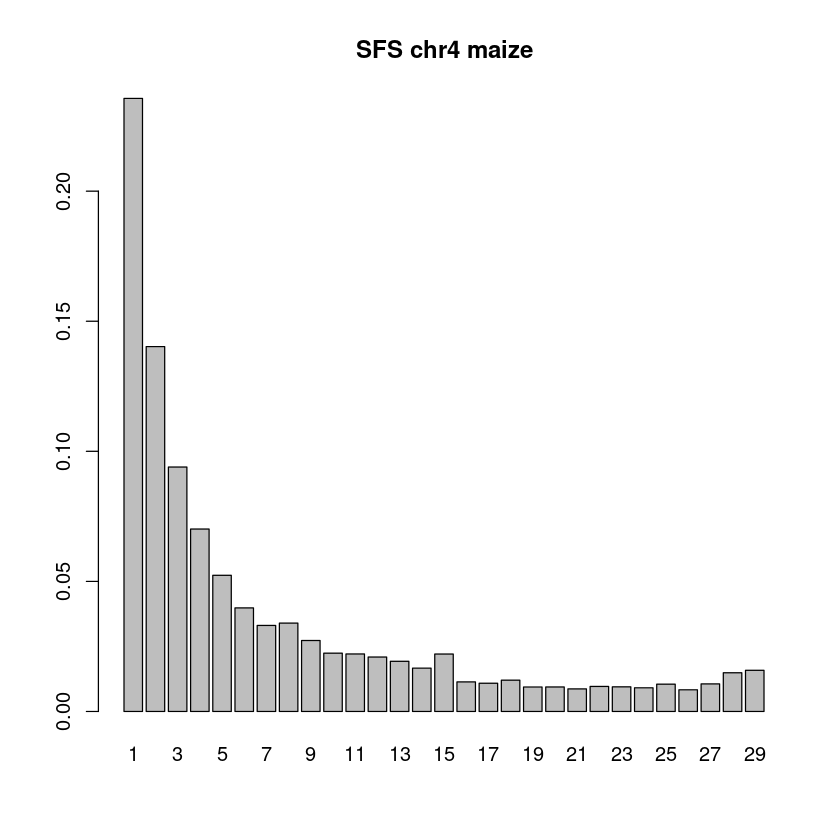

Read 31 items


In [7]:
#read the file with the SFS:
sfsmaize<-scan('~/current_folder/maize_chr4.sfs')

#exclude first column and normalise
sfsmaize<-sfsmaize[-c(1,length(sfsmaize))]
sfsmaize<-sfsmaize/sum(sfsmaize)

#create a PDF with the plot (you can also run the barplot line only)
pdf('~/current_folder/chr4_sfs.pdf')
barplot(sfsmaize, names=1:length(sfsmaize), main='SFS chr4 maize')
dev.off()

barplot(sfsmaize, names=1:length(sfsmaize), main='SFS chr4 maize')




To look at the PDF with the plot, go to the main browser tab in jypiter notebook and go to our working directory: 
 **Question**: 
 - What factors do you think could affect our SFS? 
 - What do you think we should consider when deciding which individuals/samples to include in our population?

#### 3. Calculate thetas per site
We will now use **realSFS saf2theta** to get the two diversity metrics that we need to estimate Tajima's D: theta and Pi.

In [8]:
#this might take a few minutes, so wait until it is done running:
realSFS saf2theta maize_chr4.saf.idx  \
    -sfs maize_chr4.sfs \
    -outname maize_chr4


[persaf::persaf_init] Version of maize_chr4.saf.idx is 3
[persaf::persaf_init] Assuming .saf.gz file is maize_chr4.saf.gz
[persaf::persaf_init] Assuming .saf.pos.gz file is maize_chr4.saf.pos.gz
	-> args: tole:0.000000 nthreads:4 maxiter:100 nsites(block):0 start:maize_chr4.sfs chr:(null) start:-1 stop:-1 fstout:maize_chr4 oldout:0 seed:-1 bootstrap:0 resample_chr:0 whichFst:0 fold:0 ref:(null) anc:(null)
	-> Will read chunks of size: 4096
	-> Reading: maize_chr4.sfs assuming counts (will normalize to probs internally)
	-> nChr:30
	-> Done reading data from chromosome will prepare next chromosome
	-> Is in multi sfs, will now read data from chr:4
	-> hello Im the master merge part of realSFS. and I'll now do a tripple bypass to find intersect 
	-> 1) Will set iter according to chooseChr and start and stop, and possibly using -sites
	-> Only read nSites: 0 will therefore prepare next chromosome (or exit)
	-> Done reading data from chromosome will prepare next chromosome
	-> Writing 3522

#### 4. Estimate Tajima's D
Now we will use **thetaStat** to estimate Tajima's D in 5Kb windows along chr4:

In [9]:
thetaStat do_stat \
    maize_chr4.thetas.idx \
    -win 5000 \
    -step 1000 \
    -outnames maize_chr4.thetas.5kWind


 thetaStat do_stat maize_chr4.thetas.idx -win 5000 -step 1000 -outnames maize_chr4.thetas.5kWind
	Assuming binfile:maize_chr4.thetas.gz and indexfile:maize_chr4.thetas.idx
		Information from index file:
		0	4	3522027	8	30
	 -r=(null) outnames=maize_chr4.thetas.5kWind step: 1000 win: 5000
	pc.chr=4 pc.nSites=3522027 firstpos=30555 lastpos=241908510
	Dumping file: "maize_chr4.thetas.5kWind.pestPG"



Once it is done running, let's look at the results:

In [10]:
head -n 5 maize_chr4.thetas.5kWind.pestPG


#(indexStart,indexStop)(firstPos_withData,lastPos_withData)(WinStart,WinStop)	Chr	WinCenter	tW	tP	tF	tH	tL	Tajima	fuf	fud	fayh	zeng	nSites
(159,1782)(31078,108833)(31000,36000)	4	33500	6.763158	4.250631	11.976197	8.510986	6.380808	-1.330410	-1.733252	-1.481226	-0.530547	-0.048605	1623
(285,1782)(32697,108833)(32000,37000)	4	34500	5.999502	3.978113	9.966828	8.490016	6.234064	-1.194047	-1.483449	-1.240701	-0.630713	0.033371	1497
(377,1782)(33043,108833)(33000,38000)	4	35500	5.991736	3.976013	9.938799	8.486015	6.231014	-1.192101	-1.478595	-1.235632	-0.631234	0.034083	1405
(1110,1782)(34000,108833)(34000,39000)	4	36500	3.426512	2.982402	3.904624	6.463406	4.722904	-0.430669	-0.354815	-0.228656	-0.829054	0.308509	672



Can you guess what each column is?

####  Plot the results in R

pdf 
  2

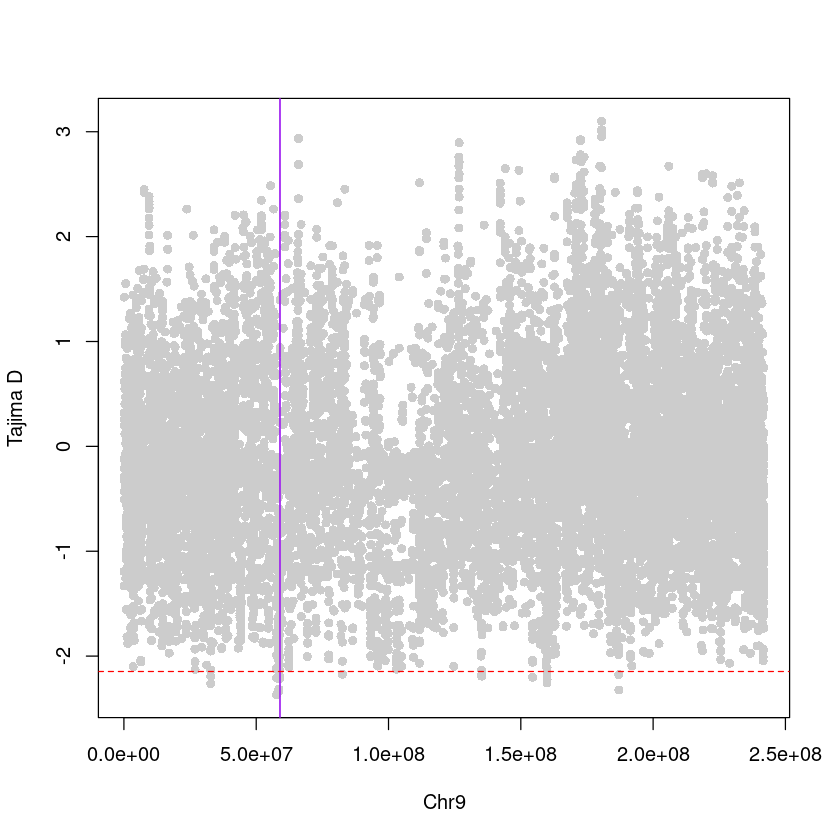

In [11]:
#read the table with the results from thetaStat:
d<-read.table('~/current_folder/maize_chr4.thetas.5kWind.pestPG', as.is=T, h=T, comment.char='')

#exclude results that are NaN due to missing data:
d<-d[!is.na(d$fuf),]

#exclude windows with less than 100 SNPs:
d<-d[d$nSites>=100,]

#identify the 0.1% windows with the most negative Tajima's D
perc01<-sort(d$Tajima)[length(d$Tajima)*0.001]

#plot the Tajima's D vs the position along chr4:
pdf('~/current_folder/TajimasD_5Kwin.pdf', useDingbats=F, width=7.5, heigh=5)

plot(as.numeric(d$WinCenter), d$Tajima, col='grey80', ylab='Tajima D',  xlab='Chr9', pch=16)

#draw a line to mark the location of bt2 gene
abline(v=c(58979526, 58985686), col='purple')

#draw a line to mark the 0.1% most negative D
abline(h=perc01, col='red', lty=2)
dev.off()

plot(as.numeric(d$WinCenter), d$Tajima, col='grey80', ylab='Tajima D',  xlab='Chr9', pch=16)

#draw a line to mark the location of bt2 gene
abline(v=c(58979526, 58985686), col='purple')

#draw a line to mark the 0.1% most negative D
abline(h=perc01, col='red', lty=2)

**Question**: 
 - Why do you think we are going for 1) negative Tajima's D and 2) the top 0.01% most negative values?

### Population Branch Statistic (PBS)
Now we will look for selection specificially in a population of ancient maize in Eastern North America (ENA). We would like to know if there has been any selection in the evolutionary lineage that gave rise to maize in ENA. We know that maize dispersed north from the domestication center reaching the US Southwest (US SW) ~4000 years ago, and then moved into ENA between 2000-1000 years ago (Figure below,left side).

So, for this exercise we will use genomic data from three populations:
- 9 genomes from the Ozarks rockshelters in ENA
- 10 genomes from the Tularosa cave in the US SW
- 16 genomes from maize's wild ancestor *Zea mays* subsp. *parviglumis*
So, given how these populations are related, we want to setup a PBS test like the one in the figure below (left side)


<img src="data_folder/Figures/Maize_migNorth.png" width="600">


#### 0. Prepare input files


Start by creating a list of BAM files for each population:


In [12]:
#Ozarks maize:
ls bamfiles/Ozark*.bam >ozarks.txt
 
#US SW maize:
ls bamfiles/Tularosa*.bam >SW750.txt

#wild maize:
ls bamfiles/TIL*.bam >parviglumis.txt



#### 1. Estimate GL for each population
Now let's estimate GL for each population independently using ANGSD (we will restrict to chr9 so that it is faster to run). Run one by one (it will take a couple of minutes each):


In [13]:
#### takes around 15 min to run all 3. So lets just copy the results
# US Southwest:
#angsd -bam SW750.txt -ref B73v3_25.fa.gz -anc TDD39103.fa.gz -out sw750_ds1 -doSaf 1 -C 50 -baq 1 -GL 2 -minMapQ 30 -minQ 20 -minInd 6 -setMinDepth 3 -doCounts 1  -r 9:1-157021084 &

# Ozarks (Eastern North America):
#angsd -bam ozarks.txt -ref B73v3_25.fa.gz -anc TDD39103.fa.gz -out ozark_ds1 -doSaf 1 -C 50 -baq 1 -GL 2 -minMapQ 30 -minQ 20 -minInd 6 -setMinDepth 3 -doCounts 1  -r 9:1-157021084 &

# Wild maize (parviglumis):
#angsd -bam parviglumis.txt -ref B73v3_25.fa.gz -anc TDD39103.fa.gz -out parviglumis_ds1 -doSaf 1 -C 50 -baq 1 -GL 2 -minMapQ 30 -minQ 20 -minInd 6 -setMinDepth 3 -doCounts 1  -r 9:1-157021084



## The he restart the kernal and copy results to your folder instead
 cp ~/data_folder/res/*ds1* .
 ls *ds1*



ozark_ds1.arg         parviglumis_ds1.arg         sw750_ds1.arg
ozark_ds1.saf.gz      parviglumis_ds1.saf.gz      sw750_ds1.saf.gz
ozark_ds1.saf.idx     parviglumis_ds1.saf.idx     sw750_ds1.saf.idx
ozark_ds1.saf.pos.gz  parviglumis_ds1.saf.pos.gz  sw750_ds1.saf.pos.gz



Check again the parameters, do they make sense to you?

#### 2. Estimate 2D-SFS
We now need to estimate the 2-dimension SFS for every combination of 2 populations (again, run one at a time):


In [14]:
# parviglumis X US SW:
realSFS parviglumis_ds1.saf.idx sw750_ds1.saf.idx > parviglumis_sw750.sfs

# parviglumis X Ozarks:
realSFS parviglumis_ds1.saf.idx ozark_ds1.saf.idx > parviglumis_ozark.sfs

# Ozarks X US SW:
realSFS ozark_ds1.saf.idx sw750_ds1.saf.idx > ozark_sw750.sfs



[persaf::persaf_init] Version of parviglumis_ds1.saf.idx is 3
[persaf::persaf_init] Assuming .saf.gz file is parviglumis_ds1.saf.gz
[persaf::persaf_init] Assuming .saf.pos.gz file is parviglumis_ds1.saf.pos.gz
[persaf::persaf_init] Version of sw750_ds1.saf.idx is 3
[persaf::persaf_init] Assuming .saf.gz file is sw750_ds1.saf.gz
[persaf::persaf_init] Assuming .saf.pos.gz file is sw750_ds1.saf.pos.gz
	-> args: tole:0.000000 nthreads:4 maxiter:100 nsites(block):0 start:(null) chr:(null) start:-1 stop:-1 fstout:(null) oldout:0 seed:-1 bootstrap:0 resample_chr:0 whichFst:0 fold:0 ref:(null) anc:(null)
[main] Multi SFS is 'still' under development. Please report strange behaviour.
	-> The choice of -nSites will require atleast: 328.087921 megabyte memory, that is at least: 0.08% of total memory
	-> dim(parviglumis_ds1.saf.idx):33
	-> dim(sw750_ds1.saf.idx):21
	-> Dimension of parameter space: 693
	-> Done reading data from chromosome will prepare next chromosome
	-> Is in multi sfs, will now

#### 3. Estimate the three-pops FST 
Now we will estimate the F_ST using our GL and 2D-SFS (the order of the populations here will determine the order of the results in the output file):

In [19]:
realSFS fst index parviglumis_ds1.saf.idx ozark_ds1.saf.idx sw750_ds1.saf.idx -fstout parviglumis_ozark_sw750 -whichFst 1 -sfs parviglumis_ozark.sfs -sfs parviglumis_sw750.sfs -sfs ozark_sw750.sfs



[persaf::persaf_init] Version of parviglumis_ds1.saf.idx is 3
[persaf::persaf_init] Assuming .saf.gz file is parviglumis_ds1.saf.gz
[persaf::persaf_init] Assuming .saf.pos.gz file is parviglumis_ds1.saf.pos.gz
[persaf::persaf_init] Version of ozark_ds1.saf.idx is 3
[persaf::persaf_init] Assuming .saf.gz file is ozark_ds1.saf.gz
[persaf::persaf_init] Assuming .saf.pos.gz file is ozark_ds1.saf.pos.gz
[persaf::persaf_init] Version of sw750_ds1.saf.idx is 3
[persaf::persaf_init] Assuming .saf.gz file is sw750_ds1.saf.gz
[persaf::persaf_init] Assuming .saf.pos.gz file is sw750_ds1.saf.pos.gz
	-> args: tole:0.000000 nthreads:4 maxiter:100 nsites(block):0 start:parviglumis_ozark.sfs chr:(null) start:-1 stop:-1 fstout:parviglumis_ozark_sw750 oldout:0 seed:-1 bootstrap:0 resample_chr:0 whichFst:1 fold:0 ref:(null) anc:(null)
	-> nSites: 100000
	-> IMPORTANT: please make sure that your saf files haven't been folded with -fold 1 in -doSaf in angsd
	-> [bhatiaFst] sfs1:32 sfs2:18 dimspace:627 
	->

####4. Estimate PBS in 5kb windowns
We estimate the FST and PBS along chromosome 4 for in windowns of 5kb:

In [20]:
realSFS fst stats2 parviglumis_ozark_sw750.fst.idx -win 5000 -step 1000  > parviglumis_ozark_sw750_chr9_5Kwin



	-> Assuming idxname:parviglumis_ozark_sw750.fst.idx
	-> Assuming .fst.gz file: parviglumis_ozark_sw750.fst.gz
	-> args: tole:0.000000 nthreads:4 maxiter:100 nsites(block):0 start:(null) chr:(null) start:-1 stop:-1 fstout:(null) oldout:0 seed:-1 bootstrap:0 resample_chr:0 whichFst:0 fold:0 ref:(null) anc:(null)
win:5000 step:1000
nSites:24401



Once it is done running, we can take a look at the results:


In [21]:
head -n 5 parviglumis_ozark_sw750_chr9_5Kwin



region	chr	midPos	Nsites	Fst01	Fst02	Fst12	PBS0	PBS1	PBS2
(26,26)(565353,565353)(565000,570000)	9	567500	2	0.016310	0.016712	0.019894	0.006601	0.009843	0.010252
(27,34)(1000300,1000308)(996000,1001000)	9	998500	9	0.038097	0.025300	0.007852	0.028293	0.010549	-0.002667
(27,34)(1000300,1000308)(997000,1002000)	9	999500	9	0.038097	0.025300	0.007852	0.028293	0.010549	-0.002667
(27,34)(1000300,1000308)(998000,1003000)	9	1000500	9	0.038097	0.025300	0.007852	0.028293	0.010549	-0.002667



#### 5. Plot the results using R


pdf 
  2

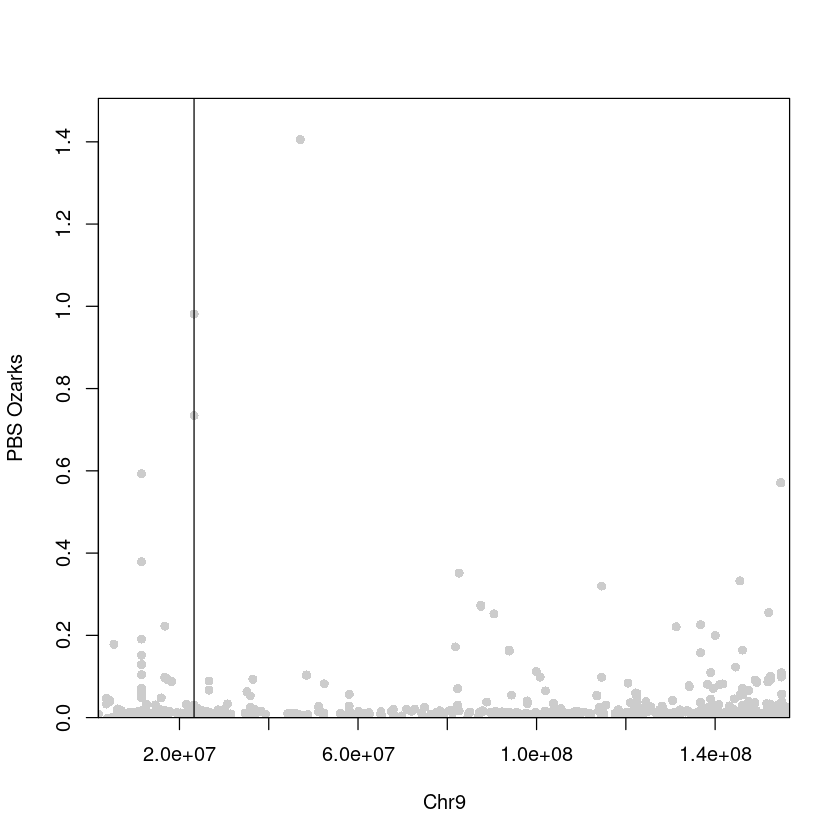

In [22]:
#read the results:
newtab<-read.table('~/current_folder/parviglumis_ozark_sw750_chr9_5Kwin', as.is=T, h=T)

#exclude windows with less than 10 SNPs:
newtab<-newtab[newtab$Nsites>=10,]

#Get the threshold for the 99.5 percentile (notice how we are ploting the PBS1, which corresponds to the PBS of the Ozarks)q995<-quantile(newtab$PBS1[!is.na(newtab$PBS1)], probs=0.995)
#This is genomic threshold for the 99.9 percentile:q999GW<-0.721893

#make the plot
pdf('~/current_folder/pbs_ozarks_5Kwin.pdf', useDingbats=F, width=7.5, heigh=5)

plot(as.numeric(newtab$midPos), newtab$PBS1, col='grey80', ylab='PBS Ozarks', ylim=c(0, max(c(newtab$PBS0, newtab$PBS1, newtab$PBS2))+0.1), yaxs='i', , xaxs='i', xlab='Chr9', pch=16)

#mark the location of the waxy gene
abline(v=newtab$midPos[newtab$midPos>=23267684 & newtab$midPos<=23271612][1], col='black')

#mark the 99.5 percentaline for chr4 and the 99.9 percentile for the whole genome:abline(h=q995, col='red', lty=2)
#abline(h=q999GW, col='mediumpurple3', lty=2)

dev.off()


plot(as.numeric(newtab$midPos), newtab$PBS1, col='grey80', ylab='PBS Ozarks', ylim=c(0, max(c(newtab$PBS0, newtab$PBS1, newtab$PBS2))+0.1), yaxs='i', , xaxs='i', xlab='Chr9', pch=16)

#mark the location of the waxy gene
abline(v=newtab$midPos[newtab$midPos>=23267684 & newtab$midPos<=23271612][1], col='black')

#mark the 99.5 percentaline for chr4 and the 99.9 percentile for the whole genome:abline(h=q995, col='red', lty=2)
#abline(h=q999GW, col='mediumpurple3', lty=2)



Let's look at the results together.